# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [9]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

del training_file
del testing_file

num_class = 43

In [10]:
###  IGNORE  ###

# from keras.datasets import cifar10
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

# num_class = 10

# training_labels         = y_train
# final_testing_labels    = y_test
# training_features       = X_train
# final_testing_features  = X_test

In [11]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(train['features'])

# TODO: number of testing examples
n_test = len(test['features'])

# TODO: what's the shape of an image?
image_shape = train['features'][0,:,:,:].shape



# TODO: how many classes are in the dataset
n_classes = len(set(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Training Data Features Shape: (39209, 32, 32, 3)


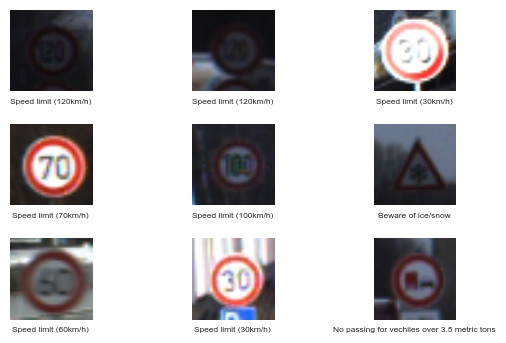

In [12]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Import data visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import csv
from sklearn.utils import shuffle

# Load image label dictionary
sign_names_csv = csv.reader(open('signnames.csv', 'r'))
image_label_dictionary = {}
for row in sign_names_csv:
    id, name = row
    if id == "ClassId":
        pass
    else:
       image_label_dictionary[int(id)] = name

# View training shape 
print ("Training Data Features Shape:",train['features'].shape)

# View random image samples 

images = []

for i in range(9):
    index = np.random.randint(0,n_train)
    img_temp = train['features'][index,:,:,:]
    img_label = image_label_dictionary[train['labels'][index]]
    images.append([img_temp,img_label])
    


fig, axes = plt.subplots(3, 3)
fig.subplots_adjust(hspace=.4,wspace=0.8)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0])
    ax.set_xlabel(images[i][1],fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])


### Data Histograms

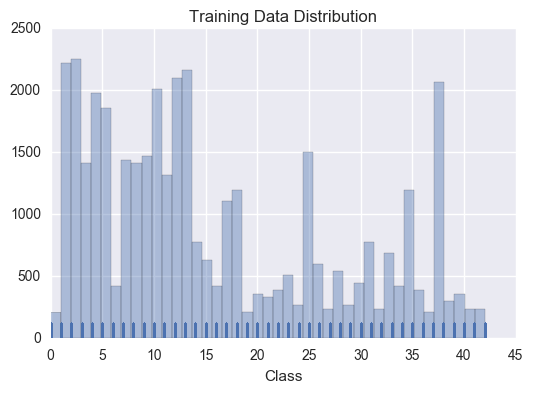

In [13]:
import pandas as pd
from scipy import stats, integrate
import seaborn as sns

sns.distplot(y_train, bins=43, kde=False, rug=True, axlabel = "Class" )
sns.plt.title('Training Data Distribution')

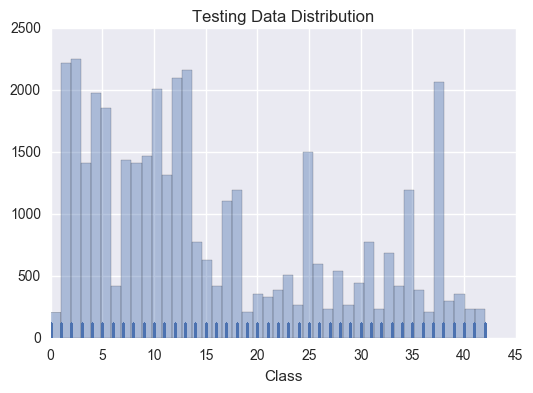

In [14]:
import pandas as pd
from scipy import stats, integrate
import seaborn as sns

sns.distplot(y_train, bins=43, kde=False, rug=True, axlabel = "Class" )
sns.plt.title('Testing Data Distribution')

## ----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Preprocess Data

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Import data preprocessing tools
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import math
import cv2

# Rename
training_labels         = train['labels']
final_testing_labels    = test['labels']
training_features       = train['features']
final_testing_features  = test['features']

# Convert data to float32 for ease of use 

training_features       = training_features.astype(np.float32)
final_testing_features  = final_testing_features.astype(np.float32)
training_labels         = training_labels.astype(np.float32)
final_testing_labels    = final_testing_labels.astype(np.float32)

# RGB to grayscale and then use min max normilization and then flatten image
def normal_grey_flatten(data):
    temp = []
    for i in range(data.shape[0]):
        image=data[i,:,:,:]
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        normalized_grey = cv2.normalize(gray_image, np.copy(gray_image), 0., 1., cv2.NORM_MINMAX, cv2.CV_32F)
        flat = np.array(normalized_grey, dtype=np.float32).flatten()
        temp.append(flat)
    return np.array(temp)

training_features = normal_grey_flatten(training_features)
final_testing_features = normal_grey_flatten(final_testing_features)
    
# Apply One-Hot Encoding to labels

encoder = LabelBinarizer()
encoder.fit(training_labels)
training_labels = encoder.transform(training_labels)
final_testing_labels = encoder.transform(final_testing_labels)

# Shuffle, Randomize and Split data
 
training_features, training_labels = shuffle(training_features, training_labels, random_state=4354)

training_features, test_features, training_labels, test_labels = train_test_split(training_features,training_labels, \
                                                                               test_size=0.15,random_state=42)

# # # Save the data 
# pickle_file = 'preprocessed_signs.pickle'
# if not os.path.isfile(pickle_file):
#     try:
#         with open('preprocessed_signs.pickle', 'wb') as pfile:
#             pickle.dump(
#                 {
#                     'training_features': training_features,
#                     'training_labels': training_labels,
#                     'test_features': test_features,
#                     'test_labels': test_labels,
#                     'final_testing_features': final_testing_features,
#                     'final_testing_labels': final_testing_labels,
#                 },
#                 pfile, pickle.HIGHEST_PROTOCOL)
#     except Exception as e:
#         print(e)
#         raise
        
        
    

#### Load Preprocessed Data

In [6]:
# # Reload the data
# pickle_file = 'preprocessed_signs.pickle'
# with open(pickle_file, 'rb') as f:
#   data = pickle.load(f)
#   training_features = data['training_features']
#   training_labels = data['training_labels']
#   test_features = data['test_features']
#   test_labels = data['test_labels']
#   final_testing_features = data['final_testing_features']
#   final_testing_labels = data['final_testing_labels']
#   del data 

## Model

#### Import Modules

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from sklearn.utils import shuffle

#### Neural Net Parameters

In [8]:
# Parameters
# learning_rate = 0.001 Not applicable with Adam Optimizer
batch_size = 75
epochs = 11


#### Helper Functions

Courtesy of Udacity and Hvass-Labs

In [9]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x,ksize=[1, k, k, 1],strides=[1, k, k, 1],padding='SAME')

def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.01))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.08, shape=shape))

#### Placeholders and Variables 

In [10]:
x = tf.placeholder(tf.float32, shape=[None, 1024])
y_true= tf.placeholder(tf.float32, shape=[None, num_class])
keep_prob = tf.placeholder(tf.float32)


### Neural Net Function

In [11]:
# Reshape from 2D to 4D.
reshape = tf.reshape(x, [-1,32,32,1])

# Set initial weights and bias for conv 1
conv1_W = weight_variable([5, 5, 1, 32])
conv1_b = bias_variable([32])

# Conv layer 1 + pool layer 1 
conv_1 = tf.nn.relu(conv2d(reshape, conv1_W, conv1_b))
pool_1 = maxpool2d(conv_1)

# Set initial weights and bias for conv 2
conv2_W = weight_variable([5, 5, 32, 64])
conv2_b = bias_variable([64])

# Conv layer 2 + pool layer 2 
conv_2 = tf.nn.relu(conv2d(pool_1, conv2_W,conv2_b))
pool_2 = maxpool2d(conv_2)

# Set initial weights and bias for fully connected 1
fully_connect_1_w = weight_variable([8 * 8 * 64, 1024])
fully_connect_1_b = bias_variable([1024])

# Flatten layer
flaten = tf.reshape(pool_2, [-1, 8*8*64])
fully_connect_1 = tf.nn.relu(tf.matmul(flaten, fully_connect_1_w) + fully_connect_1_b)

# Preform drop out
fully_connect_drop = tf.nn.dropout(fully_connect_1, keep_prob)


# Set initial weights and bias for fully connected 2
fully_connect_2_w = weight_variable([1024, num_class])
fully_connect_2_b = bias_variable([num_class])

out = tf.matmul(fully_connect_drop, fully_connect_2_w) + fully_connect_2_b


In [12]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y_true))

# Better results with AdamOptimizer than with GradientDescentOptimizer
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(out,1), tf.argmax(y_true,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# For later section
probabilities=tf.nn.softmax(out)

In [13]:
# Create Session
sess = tf.Session()

In [14]:
# Initialize Variables
sess.run(tf.initialize_all_variables())

In [15]:
#with tf.Session() as sess:
inital_time = time.time()


total_images = training_features.shape[0]
loops = int(total_images / batch_size) 

for epoch in range(epochs):
    for i in range(loops):
        batch_start = i*batch_size
        batch_features = training_features[batch_start:(batch_start + batch_size)]
        batch_labels = training_labels[batch_start:(batch_start + batch_size)] 

        if i%100 == 0:
            train_accuracy = accuracy.eval(session = sess, feed_dict={x:batch_features, y_true: batch_labels, keep_prob: 1.0})

            print("Step %d      Training Accuracy: %g"%(i, train_accuracy))
        batch_features, batch_labels = shuffle(batch_features, batch_labels, random_state=42) # New line if problems...
        sess.run(train_step,feed_dict={x: batch_features, y_true: batch_labels, keep_prob: 0.5})
        
    print ("------------------------------------------------------------------------------------------------------")
    print("Accuracy on training testing set %g"%accuracy.eval(session = sess , feed_dict={x: test_features, y_true: test_labels, keep_prob: 1.0}))
    print ("------------------------------------------------------------------------------------------------------")
    
print("Accuracy on final testing set %g"%accuracy.eval(session = sess , feed_dict={x: final_testing_features, y_true: final_testing_labels, keep_prob: 1.0}))    

print ("Finished in ", round((time.time()-inital_time)/60.)," minutes")

Step 0      Training Accuracy: 0.0133333
Step 100      Training Accuracy: 0.04
Step 200      Training Accuracy: 0.186667
Step 300      Training Accuracy: 0.413333
Step 400      Training Accuracy: 0.586667
------------------------------------------------------------------------------------------------------
Accuracy on training testing set 0.719823
------------------------------------------------------------------------------------------------------
Step 0      Training Accuracy: 0.68
Step 100      Training Accuracy: 0.76
Step 200      Training Accuracy: 0.853333
Step 300      Training Accuracy: 0.826667
Step 400      Training Accuracy: 0.88
------------------------------------------------------------------------------------------------------
Accuracy on training testing set 0.921455
------------------------------------------------------------------------------------------------------
Step 0      Training Accuracy: 0.973333
Step 100      Training Accuracy: 0.96
Step 200      Training Ac

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

That data was preprocessed by first converting training_features, final_testing_features, training_labels, final_testing_labels data to array type float32 for use with tensorflow. Following the a helper function was created to convert the color 32 x 32 images into grayscale, then apply min-max scaling with a range of 0 to 1, and the lastly the data was flattened for input into the tensorflow model. This helper fuction was applied to the training_features and final_testing_features data. After this data labels in training_labels and final_testing_labels were one hot encoded.

These actions are done to ensure a few things. First most the images were reduced to grey scale as a means of reducing the demensionality and makeing it easy to run while not giving away to much data. Next, normalization was applied to give the data a zero mean and a standard deviation of 1. Lastly, the images was flattened for input into the model. 

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

The training_features and training_labels were shuffled around with a random state. The final_training_features and final_training_labels were left unshuffled. After this using scikit learns train_test_split, training_features and training_labels, were split into training and validation data (unfortunalty my naming convention fails to easily convey this but it is present). 

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The model architecture is based off of lenet and is as follows:

1. First input array is reshaped into a 32,32,1 array. 
2. This array is feed into a 2d convolution layer with a stride of one and same padding. 
3. Relu activation was applied to the first convolution layer.
4. Max pooling was then applied to the output of the relu layer with a 2x2 kernel and a stride of 2.
5. This array is then again feed into a 2d convolution layer with a stride of one and same padding. 
6. Relu activation was applied to the second convolution layer.
7. Max pooling was again applied to the output of the second relu layer with a 2x2 kernel and a stride of 2.
8. The max pooling layer was then flattened.
9. Flaten layer was then ran through a fully connected layer.
10. Drop out is applied.
11. Dropout layer is then run thorugh final fully connected layer.

Notes on this choosen architecture: Two convolution layers were choosen to help extract and identifey the unique features of the signs and give the model the power to gather what sign it was looking at. To avoid any overfitting of this dropout was applied at 0.5 to ensure that no parameter go to comforable in this learning process. Relu was choosen as the activation layer as it gave the best results, in future may look at PReLU as an alternative. Max pooling was implemented to help reduce to overall computational intensity of the model. 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** An adam optimizer was used instead of gradient descent and proved to yeild faster results on my model (running on my cpu). Batch sizes were choosen to be lots of 75 and this was ran (IMO) excessivley for 11 epochs. But allowed me to have piece of mind. Other unique parameters were inspired by Hvass-Labs and that is the initalization std for the weights and the initialization constant for the biases. 

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** To be honest my approch came from a lot of trial and error. It is all based of the lenet architecture with a lot of playing around to work. Since this is my first time working with neural nets, this became an experiment of understanding instead of implementation. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Load Images, Reshape and Add Labels

In [19]:
import matplotlib.image as mpimg
import sys
import os
from matplotlib import gridspec

images = []

for i in os.listdir("./my_signs"):
    if i == ".DS_Store":
        pass
    else:
        image = cv2.imread("./my_signs/"+i)
        b,g,r = cv2.split(image)    # annoying...
        rgb_img = cv2.merge([r,g,b])
        images.append(rgb_img)
    
my_original_images = np.array(images)

print ("My Images Shape:",my_original_images.shape)

my_original_labels = np.array([8,17,40,22,13])

print ("My Labels Shape:",my_original_labels.shape)

My Images Shape: (5, 32, 32, 3)
My Labels Shape: (5,)


#### Plot Images

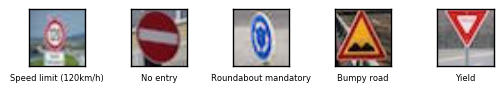

In [20]:
images = []

for i in range(5):
    img_temp = my_original_images[i,:,:,:]
    img_label = image_label_dictionary[my_original_labels[i]]
    images.append([img_temp,img_label])
    


fig, axes = plt.subplots(1, 5)
fig.subplots_adjust(hspace=.4,wspace=0.8)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0])
    ax.set_xlabel(images[i][1],fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])



#### Preprocess Images and Labels

In [21]:
# Convert data to float32 for ease of use 
my_images = my_original_images.astype(np.float32)
my_labels  = my_original_labels.astype(np.float32)

# Process images
my_images = normal_grey_flatten(my_images)
    
# Apply One-Hot Encoding to labels
my_labels = encoder.transform(my_labels)

#### Check Accuracy

In [22]:
print ("------------------------------------------------------------------------------------------------------")

print ("Accuracy on my image set %g"%accuracy.eval(session = sess , feed_dict={x: my_images, y_true: my_labels, keep_prob: 1.0}))

print ("------------------------------------------------------------------------------------------------------")

image_info=[]

for image in range(0,5):
    
    prediction = probabilities.eval(session=sess,feed_dict={x:my_images , y_true: my_labels, keep_prob: 1.0})[image]
    prob_list = list(prediction)
    original_image = my_original_images[image,:,:,:]
    original_label = my_original_labels[image]
    label_name = image_label_dictionary[my_original_labels[image]]
    image_info.append([original_image,original_label,label_name,prob_list])


------------------------------------------------------------------------------------------------------
Accuracy on my image set 0.4
------------------------------------------------------------------------------------------------------


#### Check Images and Probability Distributions

#### Helper Funciton

In [23]:
def plot_image_info(index):
    dictionary_list = image_label_dictionary.values()

    gs = gridspec.GridSpec(2, 2,width_ratios=[30,200],height_ratios=[10,1])
    plt.subplots_adjust(hspace=.4,wspace=1)
    plt.subplot(gs[0])
    plt.imshow(image_info[index][0])
    plt.title(image_info[index][2])
    plt.axis('off')


    plt.subplot(gs[1])
    plt.xlim(0,42)
    plt.title('Softmax Probabilities')
    figsize=(10,10)
    plt.bar(list(range(43)), image_info[index][3],  1/2, align='center', alpha=1)
    plt.xlabel('Classification')
    plt.xticks(rotation=90)
    plt.ylabel('Probability')
    plt.xticks(list(range(43)), dictionary_list, fontsize = 5)
    plt.setp(ax.get_xticklabels(),visible=False)
    
    pred = np.argmax(image_info[index][3])
    truth = image_info[index][1]

    print ("Classification Result :", (pred == truth) )

#### Image 1

Classification Result : False


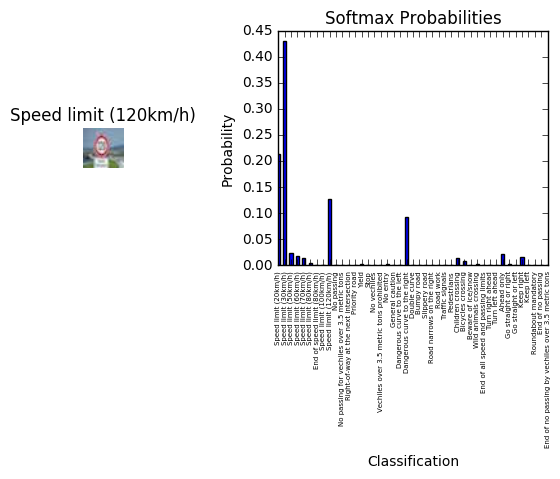

In [24]:
plot_image_info(0)

#### Image 2

Classification Result : True


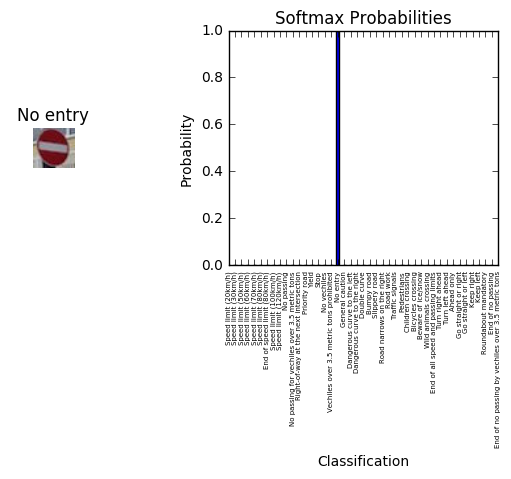

In [25]:
plot_image_info(1)

#### Image 3

Classification Result : False


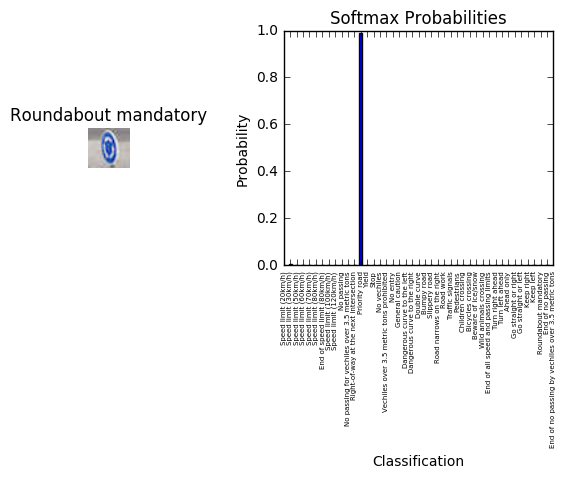

In [26]:
plot_image_info(2)

#### Image 4

Classification Result : True


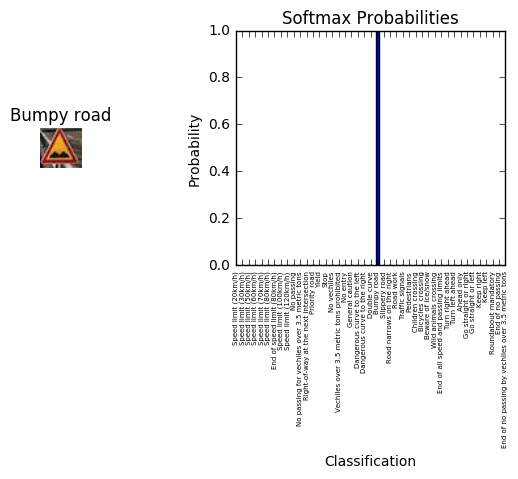

In [27]:
plot_image_info(3)

#### Image 5

Classification Result : False


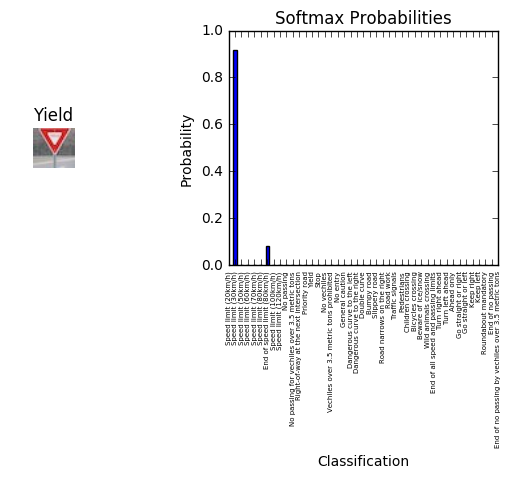

In [28]:
plot_image_info(4)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

Qualites I found for the images I choose, was that of signs that were in my data set but at an angle or different distance from that of the training set. Some with addtional noise that I assumed would make clasification more difficult. Also noting that the bumpy road sign is a different color than that of the training data. As well as the yield sign having writing in the middle. 

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

The model should be able to perform well on live camera or captured images so long as the images being fed is sucessfully cropped and its angle of view is not to extreme.

Comparing the results of the images tested here and the models accuary on its self. With more data a very robust model can be used to help idenity all new captured picutres or images from camera stream. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:** The model was certain of the no entry sign and the bumpy road sign (surprisingly). It came close to the speed sign but with the wrong speed. Granted the sign was very far away with additional noise. The roundabout mandatory failed completly in classification. The yeild sign was also classified incorrectly. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:** I dont believe this is applicable. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [31]:
# Close up shop
sess.close()

In [32]:
# Notebook created by Kyle Stewart-Frantz